# Más sobre Boosting | Extra Boosting

En este notebook vamos a ejercitar las tareas de ajuste y optimización de hiperparámetros de XGBoost (Extreme Gradient Boosting). Como vimos en la clase anterior, XGBoost es una librería de código que nació en forma independiente de sklearn, y tiene su documentación aparte. Recomendamos ver la página del proyecto:

XGBoost:
 - [Documentación:](https://xgboost.readthedocs.io/en/stable/index.html)
 - [Repositorio:](https://github.com/dmlc/xgboost)

In [ ]:
# @title Celdas preparatorias (imports + funciones plots)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.stats import norm, multivariate_normal

#Ahora las funciones utiles de sklearn para preprocesar datos y armar un pipeline
from sklearn.pipeline import Pipeline
import sklearn.preprocessing as pp

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, mean_squared_error

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Las estrellas de este notebook
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn import tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, AdaBoostRegressor, GradientBoostingRegressor, GradientBoostingClassifier

from sklearn import datasets

from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

from mpl_toolkits.mplot3d import Axes3D

def Trisurf(xname, yname, x, y, z, best_score, best_params):
    # (xname, yname): the name of variables to be displayed for visualization
    # (`x`,`y`): all the hyperparamters' datapoints on the search grid
    # (`z`): the results of the evaluation metric the results of the evaluation metric over the datapoints
    # (`best_score`, `best_params`): the Native XGBoost API's `k-fold cross-validation` function's outputs the minimum mae result and the corresponding datapoint of the hyperparameters
    fig = plt.figure(figsize=(9, 9))
    ax = fig.add_subplot(111, projection="3d")
    # Creating color map
    my_cmap = plt.get_cmap('RdPu')

    # Creating dot plot of the minimum
    ## min_mae*1.01 to float it for the visualization purpose.
    ax.scatter(best_params[0], best_params[1], best_score, color='red')
    # Tri-Surface Plot
    ax.plot_trisurf(x,y,z,cmap = my_cmap,
                         linewidth = 0.2,
                         antialiased = True,
                         edgecolor = 'grey')
    ax.set_xlabel(xname)
    ax.set_ylabel(yname)
    ax.set_zlabel('score')

    # Write the Title
    ax.set_title("Hyperparameters Performance Landscape ("+str(xname) + ' & '+str(yname)+")")

    # Download the figure as jpeg file.
    figname = str(xname) + '_'+str(yname)
    fig.savefig(str(figname) + '.jpg')

def epoch_visual(metric, evals_result, title):
    graph_title = str(title) + "_XGBoost_" + metric
    train_error = evals_result["Train"][metric]
    test_error = evals_result["Test"][metric]
    fig = plt.style.use("ggplot")

    epochs = len(evals_result["Train"][metric])
    x_axis = range(0, epochs)
    fig, ax = plt.subplots(figsize=(6,6))
    ax.plot(x_axis, evals_result["Test"][metric], label="Test")
    ax.plot(x_axis, evals_result["Train"][metric], label="Train")
    ax.legend()

    plt.xlabel("epochs")
    plt.ylabel(metric)
    plt.title(graph_title)
    plt.show()

# Primer tarea: Regresión

## Predicción del valor de propiedades (California Housing Dataset 1990)

Vamos a analizar ahora el dataset de casas de California, dataset clásico en ciencia de datos. Como recordatorio, acá van las variables de este dataset:

### About this file
 1. `longitude`: A measure of how far west a house is; a higher value is farther west
 2. `latitude`: A measure of how far north a house is; a higher value is farther north
 3. `housingMedianAge`: Median age of a house within a block; a lower number is a newer building
 4. `totalRooms`: Total number of rooms within a block
 5. `totalBedrooms`: Total number of bedrooms within a block
 6. `population`: Total number of people residing within a block
 7. `households`: Total number of households, a group of people residing within a home unit, for a block
 8. `medianIncome`: Median income for households within a block of houses (measured in tens of thousands of US Dollars)
 9. `medianHouseValue`: Median house value for households within a block (measured in US Dollars)
 10. `oceanProximity`: Location of the house with respect to ocean/sea

Referencia: [California Housing Data Set Description](https://developers.google.com/machine-learning/crash-course/california-housing-data-description)

### Carguemos los datos

In [ ]:
# Conectar Drive a Colab
from google.colab import drive
import os

# Montar drive
drive.mount("/content/drive/")
# Cambiar directorio
os.chdir('/content/drive/MyDrive/Colab Notebooks/Data/')

In [ ]:
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

california_housing = pd.read_csv('housing.zip', compression = 'zip')

### Curación y masajeo de los datos (lo vimos la clase pasada)

#### Curemos los datos

La idea de esta parte del ejercicio es insistir en el concepto importante de curar o limpiar los datos. Identificar valores faltantes, outliers, variables redundantes entre sí, etc.

#### Valores faltantes

Hay valores faltantes en la variable `total_bedrooms`. Podemos hacer dos cosas: 1) reemplazar los registros con valores faltantes (tirarlos = drop), o 2) reemplazar el valor faltante por la media (promedio). Acá yo elegí esto último.

In [ ]:
california_housing['total_bedrooms'].fillna(california_housing['total_bedrooms'].mean(), inplace=True)

#### Codifiquemos variables categóricas

Transformemos estas variables categóricas en numéricas:

In [ ]:
# nuestras categorias de proximidad ahora son numeros
def transformar_ocean_proximity(proximity):
    if proximity == '<1H mar':
        return 0
    elif proximity == 'Tierra adentro':
        return 1
    elif proximity == 'Cerca mar':
        return 2
    elif proximity == 'Cerca bahía':
        return 3
    elif proximity == 'Isla':
        return 4
california_housing['ocean_proximity'] = california_housing['ocean_proximity'].apply(transformar_ocean_proximity)

#### Removamos variables redundantes

Creamos nuevas variables `average_rooms` y `average_bedrooms` que capturan los datos de `bedrooms`y `rooms` junto con los de población, y finalmente tiramos las variables `households`, `bedrooms` y `rooms`.

In [ ]:
# hay una obvia correlación (alta) entre viviendas (households) y poblacion (population)
# vamos a remover las viviendas
california_housing.drop('households', axis=1, inplace=True)

In [ ]:
# y hay otra correlación (alta) entre número de ambientes por cuadra y número de habitaciones (para dormir) por cuadra

# asi que las vamos a reemplazar por dos nuevas variables:
# promedio de ambientes por población en la cuadra (block)
# y promedio de habitaciones por población en la cuadra
california_housing['average_rooms']    = california_housing['total_rooms'] / california_housing['population']
california_housing['average_bedrooms'] = california_housing['total_bedrooms'] / california_housing['population']

# asi que vamos a descartar estas variables
california_housing.drop('total_rooms', axis = 1, inplace = True)
california_housing.drop('total_bedrooms', axis = 1, inplace = True)


#### Outliers

Removemos outliers (`housing_median_age` y `median_house_value`).

In [ ]:
california_housing = california_housing.loc[ california_housing['housing_median_age'] <52,:]

In [ ]:
california_housing = california_housing.loc[ california_housing['median_house_value']<500001,:]

### Usemos los datos

Carguemos nuestras variables (features: X) y nuestro valor target que queremos predecir (el valor de las casas: y).

In [ ]:
X = california_housing[['longitude', 'latitude', 'housing_median_age',
                        'population', 'median_income', 'ocean_proximity',
                        'average_rooms', 'average_bedrooms']]

y = california_housing['median_house_value']

Partimos el dataset en train + test

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
import xgboost as xgb
# no ejecuta
# esta es la manera "sklearn" de usar XGBoost
ne = 300 # number of estimators
xgb_reg = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators = ne, otros_parametros....)
xgb_reg.fit(...)
# la pueden usar si quieren, pero en este notebook vamos a usar el modo nativo del paquete XGBoost

#### XGBoost nativo

Hay otra manera de usar XGBoost que no usa la manera *sklearn*. Tiene sus particularidades, pero puede dar beneficios.

En particular XGBoost tiene su propia manera de cargar datos en `DMatrices`. En lugar de numpy arrays, o dataframes de pandas, tenemos tambien las DMatrices de XGBoost. Una DMatriz puede tener datos (X) y el target (t) -- que es el valor que queremos predecir (una etiqueta en clasificación; un valor en regresión). Las DMatrices están optimizadas para hacer uso más eficiente de memoria y para la velocidad durante el entrenamiento.

Ver: [XGBoost DMatrix.](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.DMatrix)

A su vez, XGBoost tiene sus propios métodos para entrenar un modelo (`.train()`, que reemplaza a `fit()` de sklearn) y `.cv()`(cross-validation)

In [ ]:
import xgboost as xgb

# esta es la manera nativa de usar XGBoost

# cargamos los datos en una DMatrix
dmatrix  = xgb.DMatrix(data = X, label = y)        # todos los datos
DM_train = xgb.DMatrix(X_train,  label = y_train)  # train
DM_test  = xgb.DMatrix(X_test,   label = y_test)   # test

In [ ]:
# @title Algunas funciones que vamos a usar

# cross validation
def cross_validation(param_dict, DM_train, metrics, num_boost_round, early_stopping_rounds):

  cv_results = xgb.cv(
      params = param_dict,
      dtrain = DM_train,
      num_boost_round = num_boost_round,
      seed = 42, # seed for randomization
      nfold = 5, # k of k-fold cross-validation
      metrics = metrics,
      early_stopping_rounds = early_stopping_rounds
  )

  return cv_results

# performance train vs test (regresion)
def performance_train_test_reg(params):

  evals_result = {}
  model = xgb.train(
      params,
      dtrain = DM_train,
      num_boost_round = num_boost_round,
      evals=[(DM_train, "Train"), (DM_test, "Test")],
      early_stopping_rounds = early_stopping_rounds,
      evals_result = evals_result
  )
  train_error = evals_result["Train"]["mae"]
  test_error = evals_result["Test"]["mae"]
  print("Mejor MAE: {:.4f} en {} iteraciones".format(model.best_score, model.best_iteration+1))

  return model, evals_result

# performance train vs test (clasificacion)
def performance_train_test_cla(params):

  evals_result = {}
  model = xgb.train(
      params,
      dtrain = DM_train,
      num_boost_round = num_boost_round,
      evals=[(DM_train, "Train"), (DM_test, "Test")],
      early_stopping_rounds = early_stopping_rounds,
      evals_result = evals_result
  )
  train_error = evals_result["Train"]["auc"]
  test_error = evals_result["Test"]["auc"]
  print("Mejor auc: {:.4f} en {} iteraciones".format(model.best_score, model.best_iteration+1))

  return model, evals_result


# gridsearch cross-validation de a pares | regression
def pair_wise_gridsearch_CV_reg(param1_name, param2_name, gridsearch_params):

    min_mae = float("Inf")
    best_params = None

    x = []
    y = []
    z = []
    for param1, param2 in gridsearch_params:
        # Update our parameter dictionary for the tuning
        param_dict[param1_name] = param1
        param_dict[param2_name] = param2
        print("CV with {}={}, {}={}".format(param1_name, param1,
                             param2_name,
                             param2))
        # calculate cross_validation
        cv_results = cross_validation(param_dict, DM_train, metrics={'mae'}, num_boost_round=1000, early_stopping_rounds=10)
        mean_mae = cv_results['test-mae-mean'].min()
        boost_rounds = cv_results['test-mae-mean'].argmin()

        x.append(param1)
        y.append(param2)
        z.append(mean_mae)

        print("\tMAE {} en {} iteraciones".format(mean_mae, boost_rounds))

        if mean_mae < min_mae:
            min_mae = mean_mae
            best_params = (param1, param2)

    return x, y, z, min_mae, best_params

# gridsearch cross-validation de a pares | classification
def pair_wise_gridsearch_CV_cla(param1_name, param2_name, gridsearch_params):

    max_auc = 0.00
    best_params = None

    x = []
    y = []
    z = []
    for param1, param2 in gridsearch_params:
        # Update our parameter dictionary for the tuning
        param_dict[param1_name] = param1
        param_dict[param2_name] = param2
        print("CV with {}={}, {}={}".format(param1_name, param1,
                             param2_name,
                             param2))
        # calculate cross_validation
        cv_results = cross_validation(param_dict, DM_train, metrics={'auc'}, num_boost_round=1000, early_stopping_rounds=10)
        mean_auc = cv_results['test-auc-mean'].max()
        boost_rounds = cv_results['test-auc-mean'].argmin()

        x.append(param1)
        y.append(param2)
        z.append(mean_auc)

        print("\tAUC {} en {} iteraciones".format(mean_auc, boost_rounds))

        if mean_auc > max_auc:
            max_auc = mean_auc
            best_params = (param1, param2)

    return x, y, z, max_auc, best_params

In [ ]:
# cambiemos el runtime a GPU
!/usr/local/cuda/bin/nvcc --version
!nvidia-smi

### Diccionario de parámetros

Este es nuestro diccionario de parámetros inicial. NO ESTÁ OPTIMIZADO!!! Tiene los valores por defecto que vienen con XGBoost, lo vamos a usar ahora para ver como es la performance de los modelos entrenados con estos hiperparámetros (sin optimizar), y para poder comparar luego con los hiperparámetros finales.

In [ ]:
# el diccionario de parámetros
param_dict={
 'objective': 'reg:squarederror', # fijo. nuestra función objetivo para regresion.
 'eval_metric': 'mae', # fijo. nuestra metrica de evaluation
 'max_depth': 2,
 'subsample': 0.5,
 'eta': 0.5, # learning rate
 'min_child_weight': 2,
 'colsample_bytree': 0.5,
 'gamma': 2,
 'reg_alpha': 2,
 'reg_lambda': 2,
 #'tree_method': 'hist', # funciona con CPU
 'gpu_id': 0,
 'tree_method': 'gpu_hist', # exact, approx, hist (gpu_hist usa GPU pero es heuristico!)
 # ver https://xgboost.readthedocs.io/en/stable/gpu/index.html
 # ver https://xgboost.readthedocs.io/en/stable/treemethod.html
}

num_boost_round = 300     # n_estimators
early_stopping_rounds = 10 # Validation error needs to decrease at least every early_stopping_rounds to continue training.

In [ ]:
pre_model, pre_evals_result = performance_train_test_reg(params = param_dict)

In [ ]:
pre_best_performance = pre_model.best_score
print("Minimum absolute error (MAE) previo a la optimización:\n", pre_best_performance)
pasos = ["Pre"]
min_maes = [pre_best_performance]

In [ ]:
# curva de aprendizaje
epoch_visual("mae", evals_result = pre_evals_result, title="Pre Optimizacion")

### Ahora vamos a ir optimizando parámetros de a pares

Usando la función `pair_wise_gridsearch_CV` que está en el bloque anterior, vamos a ir tomando hiperparámetros de a pares y vamos a ir optimizando.



#### Primero: max_depth + eta (learning_rate)



In [ ]:
# nuestra grilla de parámetros para este primer paso:
pair_wise_gridsearch_params1 = [
    (max_depth, eta)
    for max_depth in range(3,10) # max_depth entre 3 -- 9
    for eta in [i/10. for i in range(1, 10)] # eta entre 0.1 -- 0.9
]

Y ahora llamamos a nuestra función `pair_wise_gridsearch_CV` que nos devuelve:
 - `x1` + `y1` que contienen todos los valores de los pares de estos hyperparametros en la grilla;
 - `z1` almacena el valor de la performance para cada par (`x1`, `y1`);
 - `min_mae1` almacena la mejor performance, el minimo de la funcion de perdida (loss function).
 - `best_params1` almacena el par de valores de los hiperparametros que dieron la mejor performance.
 - `min_mae1` + `best_params1` SON el resultado de esta optimización de a pares

In [ ]:
x1, y1, z1, min_mae1, best_params1 = pair_wise_gridsearch_CV_reg('max_depth', 'eta', pair_wise_gridsearch_params1)

In [ ]:
print("1 - Mejores valores para estos hiperparámetros:", best_params1, "MAE:", min_mae1)

In [ ]:
Trisurf("max_depth", 'eta', x1, y1, z1, min_mae1, best_params1)

In [ ]:
# y ahora actualizamos nuestro diccionario de parámetros
param_dict["max_depth"] = best_params1[0]
param_dict["eta"]       = best_params1[1]

In [ ]:
param_dict["eta"]

In [ ]:
model1, evals_result_1 = performance_train_test_reg(params = param_dict)
pasos.append("Primero")
min_maes.append(model1.best_score)

In [ ]:
epoch_visual("mae", evals_result = evals_result_1, title="Primer Paso")

#### Segundo: submuestreos (subsample + colsample_bytree)

In [ ]:
# nuestros rangos de valores para nuestro segundo par de hiperparametros
pair_wise_gridsearch_params2 = [
    (subsample, colsample_bytree)
    for subsample in [i/10. for i in range(1, 10)]        # subsample entre 0.1 y 0.9
    for colsample_bytree in [i/10. for i in range(1, 10)] # colsample_bytree entre 0.1 y 0.9
]

In [ ]:
x2, y2, z2, min_mae2, best_params2 = pair_wise_gridsearch_CV_reg('subsample', 'colsample_bytree', pair_wise_gridsearch_params2)

In [ ]:
print("2 - Mejores valores para estos hiperparámetros:", best_params2, "MAE:", min_mae2)

In [ ]:
Trisurf("subsample", 'colsample_bytree', x2, y2, z2, min_mae2, best_params2)

In [ ]:
# volvemos a actualizar el diccionario de parámetros
param_dict["subsample"]         = best_params2[0]
param_dict["colsample_bytree"]  = best_params2[1]

In [ ]:
model2, evals_result_2 = performance_train_test_reg(params = param_dict)
pasos.append("Segundo")
min_maes.append(model2.best_score)

In [ ]:
# curva de aprendizaje
epoch_visual("mae", evals_result = evals_result_2, title="Segundo Paso")

#### Tercer par de hiperparámetros (min_child_weight + gamma)

`min_child_weight` controla el peso de los datos que son hojas (nodos terminales) de un árbol. Si al generar una nueva partición de los datos, el peso del nodo hijo (terminal) es menor que este valor, XGBoost cancela esa partición (split).

`gamma` es el `min_split_loss` que es la reducción mínima de la pérdida que requerimos para que XGBoost haga una partición sobre un nodo hoja (terminal) del árbol. Cuanto mas grande es `gamma` más conservador es el algoritmo.

In [ ]:
# nuestros rangos de valores para nuestro segundo par de hiperparametros
pair_wise_gridsearch_params3 = [
    (min_child_weight, gamma)
    for min_child_weight in range(0, 10)  # min_child_weight 0 - 9
    for gamma in range(0, 10)             # gamma 0 - 9
]

In [ ]:
x3, y3, z3, min_mae3, best_params3 = pair_wise_gridsearch_CV_reg('min_child_weight', 'gamma', pair_wise_gridsearch_params3)

In [ ]:
print("3 - Mejores valores para estos hiperparámetros:", best_params3, "MAE:", min_mae3)

In [ ]:
Trisurf("min_child_weight", 'gamma', x3, y3, z3, min_mae3, best_params3)

In [ ]:
# nuevamente, actualizamos nuestro diccionario de parámetros
param_dict["min_child_weight"]  = best_params3[0]
param_dict["gamma"]             = best_params3[1]

In [ ]:
model3, evals_result_3 = performance_train_test_reg(params = param_dict)
pasos.append("Tercero")
min_maes.append(model3.best_score)

In [ ]:
# curva de aprendizaje
epoch_visual("mae", evals_result = evals_result_3, title="Tercer Paso")

#### Cuarto: Regularización

El cuarto par de hiperparámetros: reg_alpha and reg_lambda

In [ ]:
pair_wise_gridsearch_params4 = [
    (reg_alpha, reg_lambda)
    for reg_alpha in [0, 1e-2, 0.1, 1, 2, 3, 4, 8, 10, 12, 14]
    for reg_lambda in [0, 1e-2, 0.1, 1, 2, 3, 4, 8, 10, 12, 14]
]

In [ ]:
x4, y4, z4, min_mae4, best_params4 = pair_wise_gridsearch_CV_reg('reg_alpha', 'reg_lambda', pair_wise_gridsearch_params4)

In [ ]:
print("4 - Mejores valores para estos hiperparámetros:", best_params4, "MAE:", min_mae4)

In [ ]:
Trisurf('reg_lambda', 'reg_alpha', y4, x4, z4, min_mae4, best_params4)

In [ ]:
param_dict["reg_alpha"]   = best_params4[0]
param_dict["reg_lambda"]  = best_params4[1]

In [ ]:
model4, evals_result_4 = performance_train_test_reg(params = param_dict)
pasos.append("Cuarto")
min_maes.append(model4.best_score)

In [ ]:
# curva de aprendizaje
epoch_visual("mae", evals_result = evals_result_4, title="Cuarto Paso")

#### Modelo Final

In [ ]:
import pprint
pretty = pprint.PrettyPrinter(width = 80)
print("Hiperparametros despues de optimizacion de a pares:")
pretty.pprint(param_dict)

In [ ]:
y_pred2 = model4.predict(DM_test)

In [ ]:
# Veamos graficamente las primeras n predicciones
n = 200
grp = pd.DataFrame({'prediccion':y_pred2,'real':y_test})
grp = grp.reset_index()
grp = grp.drop(['index'],axis=1)
plt.style.use('ggplot')
plt.figure(figsize=(16,6))
plt.plot(grp[:n],linewidth=2)
plt.xlabel('Eventos', fontsize=12)
plt.ylabel('Median House Value', fontsize=12)
plt.legend(['Real','Predicción'],prop={'size': 12})
sns.jointplot(x="real", y="prediccion", data=grp, kind="reg")

In [ ]:
# Plot the feature importance
xgb.plot_importance(model4);
plt.tight_layout()

In [ ]:
# Minimum Absolute Error (MAE) a lo largo de la optimizacion por pares
plt.figure(figsize=(9, 6))
plt.plot(pasos, min_maes)
plt.ylim([26000, 35000])
plt.title('MAE en la optimizacion')

In [ ]:
# cuantos arboles hay?
dump = model4.get_dump()
num_trees = len(dump)
print(num_trees)

In [ ]:
from xgboost import plot_tree
from matplotlib.pylab import rcParams

# parametros de ploteo
rcParams['font.size'] = 16

# plotear el arbol (LR = sideways)
# num_trees va de 0 (1er arbol) hasta el ultimo ...
fig, ax = plt.subplots(figsize=(36, 36))
xgb.plot_tree(model4, rankdir="LR", num_trees=0, ax=ax);

### Guardar y reusar modelos



In [ ]:
model4.save_model('california-housing-modelo-entrenado-optimizado')
# volcar (dump) el modelo a un archivo
model4.dump_model('california-housing-modelo-entrenado-optimizado.raw.txt')
# volcar con mapa de features
#model4.dump_model('california-housing-modelo-entrenado-optimizado.raw.txt', 'featmap.txt')

In [ ]:
# save to JSON
model4.save_model("model.json")
# save to text format
model4.save_model("model.txt")

model.load_model("")

### Optimizar hiperparámetros fuerte

XGBoost tiene muchos hiperparámetros, pueden consultar la guia en la documentación oficial ([XGBoost Parameters](https://xgboost.readthedocs.io/en/stable/parameter.html)). Hacer un GridSearchCV con una lista muy grande de parámetros y explorar valores, es posible.



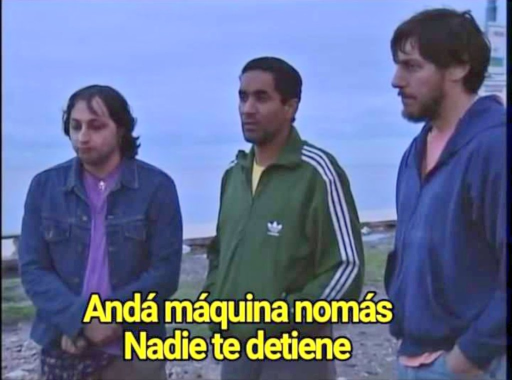

In [ ]:
# si son valientes acá va la receta de un GridSearchCV posible
# pueden agregarle ingredientes, hacer una reducción, o condimentarlo a gusto
from sklearn.model_selection import GridSearchCV

xgb_gscv = xgb.XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear', 'reg:squarederror'], # dos objetivos, por qué no?
              'eval_metric': ['mae'],
              'learning_rate': [0.05, .075, 0.1, 0.125, 0.15, 0.3, 0.6, 0.9], # eta, shrinkage
              'max_depth': [5, 7, 9, 11, 13, 15],
              'min_child_weight': [4, 5, 6],
              'silent': [1], # chito la boca
              'subsample': [0.6, 0.7, 0.8, 0.9],
              'colsample_bytree': [0.5, 0.6, 0.7, 0.9],
              'reg_lambda': [2, 4, 6, 8, 10, 12, 14],
              'reg_alpha': [2, 4, 6, 8, 10, 12, 14],
              'n_estimators': [500, 1000]}

xgb_grid = GridSearchCV(xgb_gscv,
                        parameters,
                        cv = 5,
                        n_jobs = 10,
                        verbose = True)

xgb_grid.fit(X_train,y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

### Parámetros de XGBoost

Los parámetros de XGBoost se pueden divir en categorias:
 - Generales
   - Verbosidad: mensajes en consola
   - nthreads: cuantos hilos del procesador usar
 - Parámetros del Booster (base learners)
   - Dependen de la eleccion del modelo de base (el que aprende)
   - Por defecto: gbtree (gradient boost tree)
 - Parámetros de la tarea de aprendizaje:
   - `objective`: la función objetivo a optimizar (regression).
   - `eval_metric`: select the performance evaluation metric for regression
   - `gpu_id:` 0 (el valor que nos devuelve nvidia-smi)
   - `tree_method`: gpu_hist para seleccionar GPU


 A su vez, los podemos dividir por los distintos tipos de funciones que controlan estos hiperparámetros:
  - Controles de iteración: `num_boost_round` (es `n_estimators`!), `early_stopping_round`
  - Contracción (shrinkage): `eta` (también llamado `learning_rate`)
  - Limitaciones a los árboles: `max_depth`, `min_child_weight`, `gamma` (min_split_loss)
  - Submuestreo: `subsample`, `colsample_bytree`
  - Regularización: `alpha` (L1), `lambda` (L2)


En casos de GridSearch por fuerza bruta (combinatoria de todos vs todos), no tiene mucho sentido clasificarlos, pero si intentan hacer una optimizacion por grupos de parámetros por ahi tiene sentido enfrentar parámetros de la misma categoría (ej submuestreos por fila vs columna).  

# Segunda Tarea: Clasificación

Para ejercitar vamos a usar dos tareas / datasets. Por un lado la base de datos de diabetes de indios Pima. Los indios Pima son una población humana en

## La base de datos de diabetes de indios Pima

La base de datos tiene 9 variables, una de las cuales es el Outcome (clase), donde `0` indica un test negativo de diabetes, y `1` implica un test positivo (tiene Diabetes).

**Referencias:**
 - Schulz LO, Chaudhari LS (2015). High-Risk Populations: The Pimas of Arizona and Mexico. Curr Obes Rep. 4(1):92-8. [DOI:10.1007/s13679-014-0132-9](https://doi.org/10.1007/s13679-014-0132-9).
 - [Kaggle: Pima Indians Diabetes Database.](https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database)

In [ ]:
# Conectar Drive a Colab
from google.colab import drive
import os

# Montar drive
drive.mount("/content/drive/")
# Cambiar directorio
os.chdir('/content/drive/MyDrive/Colab Notebooks/Data/')

In [ ]:
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

diabetes = pd.read_csv('diabetes.zip', compression = 'zip')

In [ ]:
diabetes.head(10)

In [ ]:
diabetes.count()

In [ ]:
X = diabetes[['Pregnancies', 'Glucose', 'BloodPressure',
              'SkinThickness', 'Insulin', 'BMI',
              'DiabetesPedigreeFunction', 'Age']]

y = diabetes['Outcome']

Partimos el dataset en train + test

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
import xgboost as xgb

# esta es la manera nativa de usar XGBoost
# cargamos los datos en una DMatrix
dmatrix  = xgb.DMatrix(data = X, label = y)        # todos los datos
DM_train = xgb.DMatrix(X_train,  label = y_train)  # train
DM_test  = xgb.DMatrix(X_test,   label = y_test)   # test

### Nuestro nuevo diccionario de parámetros

Acá, como nuestra tarea es clasificación, vamos a cambiar la función objetivo (la que XGBoost usa para guiar la selección de árboles, splits, etC), y también nuestra métrica de evaluación.

Para tareas de clasificación binaria como en este caso (tiene diabetes, no tiene diabetes), podemos usar la función objetivo `binary:logistic`.

Como vimos en clases anteriores, podemos usar el valor de Area Bajo la Curva ROC (AUC), y en XGBoost lo podemos hacer con `eval_metric = 'auc'`, o podemos también usar el valor de Area Bajo la Curva Precision-Recall, que en XGBoost es `eval_metric = 'auc'`.

Recuerden que la métrica tiene que estar alineada con el objetivo! Las que funcionan para clasificación no tienen sentido para regresiones (y *vice versa*).

Referencia: [XGBoost Learning Task Parameters.](https://xgboost.readthedocs.io/en/latest/parameter.html#learning-task-parameters)

In [ ]:
# el diccionario de parámetros
param_dict={
 'objective': 'binary:logistic', # fijo. nuestra función objetivo para clasificacion.
 'eval_metric': 'auc', # fijo. nuestra metrica de evaluation (AUC P-R)
 'max_depth': 4,
 'subsample': 0.3,
 'eta': 0.6,
 'min_child_weight': 2,
 'colsample_bytree': 0.5,
 'gamma': 1,
 'reg_alpha': 2,
 'reg_lambda': 2,
 #'tree_method': 'hist', # para CPU
 'seed': 42,
 'gpu_id': 0,
 'tree_method': 'gpu_hist', # exact, approx, hist (gpu_hist usa GPU pero es heuristico!)
 # ver https://xgboost.readthedocs.io/en/stable/gpu/index.html
 # ver https://xgboost.readthedocs.io/en/stable/treemethod.html
}

num_boost_round = 300     # n_estimators
early_stopping_rounds = 10 # Validation error needs to decrease at least every early_stopping_rounds to continue training.

In [ ]:
pre_model, pre_evals_result = performance_train_test_cla(params = param_dict)

In [ ]:
pre_best_performance = pre_model.best_score
print("Area Bajo la Curva previo a la optimización:\n", pre_best_performance)
pasos_diabetes = ["Pre"]
aucs = [pre_best_performance]

In [ ]:
# curva de aprendizaje
epoch_visual("auc", evals_result = pre_evals_result, title="Pre Optimizacion")

### Ahora vamos a ir optimizando parámetros de a pares

Usando la función `pair_wise_gridsearch_CV` que está en el bloque anterior, vamos a ir tomando hiperparámetros de a pares y vamos a ir optimizando.



#### Primero: max_depth + eta (learning_rate)



In [ ]:
# nuestra grilla de parámetros para este primer paso:
pair_wise_gridsearch_params1 = [
    (max_depth, eta)
    for max_depth in range(3,10) # max_depth entre 3 -- 9
    for eta in [i/10. for i in range(1, 10)] # eta entre 0.1 -- 0.9
]

Y ahora llamamos a nuestra función `pair_wise_gridsearch_CV` que nos devuelve:
 - `x1` + `y1` que contienen todos los valores de los pares de estos hyperparametros en la grilla;
 - `z1` almacena el valor de la performance para cada par (`x1`, `y1`);
 - `min_mae1` almacena la mejor performance, el minimo de la funcion de perdida (loss function).
 - `best_params1` almacena el par de valores de los hiperparametros que dieron la mejor performance.
 - `min_mae1` + `best_params1` SON el resultado de esta optimización de a pares

In [ ]:
x1, y1, z1, max_auc1, best_params1 = pair_wise_gridsearch_CV_cla('max_depth', 'eta', pair_wise_gridsearch_params1)

In [ ]:
print("1 - Mejores valores para estos hiperparámetros:", best_params1, "auc:", max_auc1)

In [ ]:
Trisurf('eta', "max_depth", y1, x1, z1, max_auc1, best_params1)

In [ ]:
# y ahora actualizamos nuestro diccionario de parámetros
param_dict["max_depth"] = best_params1[0]
param_dict["eta"]       = best_params1[1]

In [ ]:
model1, evals_result_1 = performance_train_test_cla(params = param_dict)
pasos_diabetes.append("Primero")
aucs.append(model1.best_score)

In [ ]:
epoch_visual("auc", evals_result = evals_result_1, title="Primer Paso")

#### Segundo: submuestreos (subsample + colsample_bytree)

In [ ]:
# nuestros rangos de valores para nuestro segundo par de hiperparametros
pair_wise_gridsearch_params2 = [
    (subsample, colsample_bytree)
    for subsample in [i/10. for i in range(1, 10)]        # subsample entre 0.1 y 0.9
    for colsample_bytree in [i/10. for i in range(1, 10)] # colsample_bytree entre 0.1 y 0.9
]

In [ ]:
x2, y2, z2, max_auc2, best_params2 = pair_wise_gridsearch_CV_cla('subsample', 'colsample_bytree', pair_wise_gridsearch_params2)

In [ ]:
print("2 - Mejores valores para estos hiperparámetros:", best_params2, "auc:", max_auc2)

In [ ]:
Trisurf("subsample", 'colsample_bytree', x2, y2, z2, max_auc2, best_params2)

In [ ]:
# volvemos a actualizar el diccionario de parámetros
param_dict["subsample"]         = best_params2[0]
param_dict["colsample_bytree"]  = best_params2[1]

In [ ]:
model2, evals_result_2 = performance_train_test_cla(params = param_dict)
pasos_diabetes.append("Segundo")
aucs.append(model2.best_score)

In [ ]:
# curva de aprendizaje
epoch_visual("auc", evals_result = evals_result_2, title="Segundo Paso")

#### Tercer par de hiperparámetros (min_child_weight + gamma)

`min_child_weight` controla el peso de los datos que son hojas (nodos terminales) de un árbol. Si al generar una nueva partición de los datos, el peso del nodo hijo (terminal) es menor que este valor, XGBoost cancela esa partición (split).

`gamma` es el `min_split_loss` que es la reducción mínima de la pérdida que requerimos para que XGBoost haga una partición sobre un nodo hoja (terminal) del árbol. Cuanto mas grande es `gamma` más conservador es el algoritmo.

In [ ]:
# nuestros rangos de valores para nuestro segundo par de hiperparametros
pair_wise_gridsearch_params3 = [
    (min_child_weight, gamma)
    for min_child_weight in range(0, 10)  # min_child_weight 0 - 9
    for gamma in range(0, 10)             # gamma 0 - 9
]

In [ ]:
x3, y3, z3, max_auc3, best_params3 = pair_wise_gridsearch_CV_cla('min_child_weight', 'gamma', pair_wise_gridsearch_params3)

In [ ]:
print("3 - Mejores valores para estos hiperparámetros:", best_params3, "auc:", max_auc3)

In [ ]:
Trisurf("min_child_weight", 'gamma', x3, y3, z3, max_auc3, best_params3)

In [ ]:
# nuevamente, actualizamos nuestro diccionario de parámetros
param_dict["min_child_weight"]  = best_params3[0]
param_dict["gamma"]             = best_params3[1]

In [ ]:
model3, evals_result_3 = performance_train_test_cla(params = param_dict)
pasos_diabetes.append("Tercero")
aucs.append(model3.best_score)

In [ ]:
# curva de aprendizaje
epoch_visual("auc", evals_result = evals_result_3, title="Tercer Paso")

#### Cuarto: Regularización

El cuarto par de hiperparámetros: reg_alpha and reg_lambda

In [ ]:
pair_wise_gridsearch_params4 = [
    (reg_alpha, reg_lambda)
    for reg_alpha in [0, 1e-2, 0.1, 1, 2, 3, 4, 8, 10, 12, 14]
    for reg_lambda in [0, 1e-2, 0.1, 1, 2, 3, 4, 8, 10, 12, 14]
]

In [ ]:
x4, y4, z4, max_auc4, best_params4 = pair_wise_gridsearch_CV_cla('reg_alpha', 'reg_lambda', pair_wise_gridsearch_params4)

In [ ]:
print("4 - Mejores valores para estos hiperparámetros:", best_params4, "auc:", max_auc4)

In [ ]:
Trisurf('reg_lambda', 'reg_alpha', y4, x4, z4, max_auc4, best_params4)

In [ ]:
param_dict["reg_alpha"]   = best_params4[0]
param_dict["reg_lambda"]  = best_params4[1]

In [ ]:
model4, evals_result_4 = performance_train_test_cla(params = param_dict)
pasos_diabetes.append("Cuarto")
aucs.append(model4.best_score)

In [ ]:
# curva de aprendizaje
epoch_visual("auc", evals_result = evals_result_4, title="Cuarto Paso")

#### Modelo Final

In [ ]:
import pprint
pretty = pprint.PrettyPrinter(width = 80)
print("Hiperparametros despues de optimizacion de a pares:")
pretty.pprint(param_dict)

In [ ]:
# Area Bajo la Curva Precision-Recall (auc) a lo largo de la optimizacion por pares
plt.figure(figsize=(9, 6))
plt.plot(pasos_diabetes, aucs)
plt.ylim([0, 1])
plt.title('auc en la optimizacion')

In [ ]:
y_pred2 = model4.predict(DM_test)

In [ ]:
# Plot the feature importance
xgb.plot_importance(model4);
plt.tight_layout()

In [ ]:
# cuantos arboles hay?
dump = model4.get_dump()
num_trees = len(dump)
print(num_trees)

In [ ]:
from xgboost import plot_tree
from matplotlib.pylab import rcParams

# parametros de ploteo
rcParams['font.size'] = 16

# plotear el arbol (LR = sideways)
# num_trees va de 0 (1er arbol) hasta el ultimo ...
fig, ax = plt.subplots(figsize=(36, 36))
xgb.plot_tree(model4, rankdir="LR", num_trees=0, ax=ax);